# Predict Customer Churn using PySpark Machine Learning

In [ ]:
!pip install pyspark

!pip install -U -q PyDrive

!apt install openjdk-8-jdk-headless -qq

import os

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

openjdk-8-jdk-headless is already the newest version (8u272-b10-0ubuntu1~18.04).
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.


## Sparkify Project Workspace

In [ ]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import add_months, avg, count, countDistinct, col, datediff,\
desc, expr, from_unixtime, floor, isnan, lag, lit, month, months_between,\
min, max, split, sum, udf, unix_timestamp, when, year
from pyspark.sql.types import IntegerType, DateType
from pyspark.sql.window import Window

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, GBTClassifier, LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from datetime import datetime

In [ ]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Sparkify") \
    .getOrCreate()

# Load and Clean Dataset

In [ ]:
df = spark.read.json('/content/mini_sparkify_event_data.json')
df.head()

Row(_corrupt_record='e":"Alexander","registration":1536817381000,"gender":"M","artist":"Intocable","song":"Tiempo","length":207.0722}', artist=None, auth=None, firstName=None, gender=None, itemInSession=None, lastName=None, length=None, level=None, location=None, method=None, page=None, registration=None, sessionId=None, song=None, status=None, ts=None, userAgent=None, userId=None)

In [ ]:
df.printSchema()

root
 |-- _corrupt_record: string (nullable = true)
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [ ]:
df.head()

Row(_corrupt_record='e":"Alexander","registration":1536817381000,"gender":"M","artist":"Intocable","song":"Tiempo","length":207.0722}', artist=None, auth=None, firstName=None, gender=None, itemInSession=None, lastName=None, length=None, level=None, location=None, method=None, page=None, registration=None, sessionId=None, song=None, status=None, ts=None, userAgent=None, userId=None)

# Investigate timestamps

In [ ]:
df.describe("ts").show()

+-------+--------------------+
|summary|                  ts|
+-------+--------------------+
|  count|              279402|
|   mean|1.541020348015104...|
| stddev|1.4723451594213476E9|
|    min|       1538374371000|
|    max|       1543799476000|
+-------+--------------------+



In [ ]:
ts = int(1538352117000)
ts /= 1000
print("Start Time: {}".format(datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')))

ts = int(1543799476000)
ts /= 1000
print("End Time: {}".format(datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')))

Start Time: 2018-10-01 00:01:57
End Time: 2018-12-03 01:11:16


# Investigate pages

In [ ]:
df.select("page").dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|                null|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
| Submit Registration|
|            Settings|
|               Login|
|            Register|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
+--------------------+
only showing top 20 rows



In [ ]:
df.filter(df.page=="Cancel").show(4)

+---------------+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+------+-------------+---------+----+------+-------------+--------------------+------+
|_corrupt_record|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|  page| registration|sessionId|song|status|           ts|           userAgent|userId|
+---------------+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+------+-------------+---------+----+------+-------------+--------------------+------+
|           null|  null|Logged In|   Adriel|     M|          103| Mendoza|  null| paid|  Kansas City, MO-KS|   PUT|Cancel|1535623466000|      514|null|   307|1538943740000|"Mozilla/5.0 (Mac...|    18|
|           null|  null|Logged In|    Diego|     M|           55|   Mckee|  null| paid|Phoenix-Mesa-Scot...|   PUT|Cancel|1537167593000|      540|null|   307|1539033031000|"Mozilla/5.0 (iPh...|   

In [ ]:
df.filter(df.page=="Submit Downgrade").show(4)

+---------------+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+
|_corrupt_record|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|            page| registration|sessionId|song|status|           ts|           userAgent|userId|
+---------------+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+
|           null|  null|Logged In|  Kaylenn|     F|          354| Jenkins|  null| paid|           Price, UT|   PUT|Submit Downgrade|1535903878000|      479|null|   307|1538835479000|"Mozilla/5.0 (Mac...|   141|
|           null|  null|Logged In|    Colin|     M|          214| Freeman|  null| paid|     Bakersfield, CA|   PUT|Submit Downgrade|1538173362000|      532|

In [ ]:
df.filter(df.page=="Cancellation Confirmation").show(4)

+---------------+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+
|_corrupt_record|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|                page| registration|sessionId|song|status|           ts|           userAgent|userId|
+---------------+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+
|           null|  null|Cancelled|   Adriel|     M|          104| Mendoza|  null| paid|  Kansas City, MO-KS|   GET|Cancellation Conf...|1535623466000|      514|null|   200|1538943990000|"Mozilla/5.0 (Mac...|    18|
|           null|  null|Cancelled|    Diego|     M|           56|   Mckee|  null| paid|Phoenix-Mesa-Scot...|   GET|Cancellation Conf...|1537

In [ ]:
# both free and premium have adverts
df.filter(df.page=="Roll Advert").show(4)

+---------------+------+---------+---------+------+-------------+---------+------+-----+--------------------+------+-----------+-------------+---------+----+------+-------------+--------------------+------+
|_corrupt_record|artist|     auth|firstName|gender|itemInSession| lastName|length|level|            location|method|       page| registration|sessionId|song|status|           ts|           userAgent|userId|
+---------------+------+---------+---------+------+-------------+---------+------+-----+--------------------+------+-----------+-------------+---------+----+------+-------------+--------------------+------+
|           null|  null|Logged In|    Jaxon|     M|           21|   Reilly|  null| free|    Jacksonville, FL|   GET|Roll Advert|1531760527000|      226|null|   200|1538561090000|Mozilla/5.0 (Wind...|    86|
|           null|  null|Logged In|  Miracle|     F|           23|       Ho|  null| free|Atlanta-Sandy Spr...|   GET|Roll Advert|1534613601000|      318|null|   200|15385623

In [ ]:
df.filter(df.page=="Save Settings").show(4)

+---------------+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+-------------+-------------+---------+----+------+-------------+--------------------+------+
|_corrupt_record|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|         page| registration|sessionId|song|status|           ts|           userAgent|userId|
+---------------+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+-------------+-------------+---------+----+------+-------------+--------------------+------+
|           null|  null|Logged In|  Madelyn|     F|           47|  Henson|  null| paid|Charlotte-Concord...|   PUT|Save Settings|1532920994000|      366|null|   307|1538589858000|"Mozilla/5.0 (Mac...|   113|
|           null|  null|Logged In|Alexander|     M|           72|  Garcia|  null| paid|Indianapolis-Carm...|   PUT|Save Settings|1536817381000|      390|null|   307|153

In [ ]:
df.filter(df.page=="NextSong").show(4)

+---------------+---------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+--------+-------------+---------+-------------------+------+-------------+--------------------+------+
|_corrupt_record|         artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|    page| registration|sessionId|               song|status|           ts|           userAgent|userId|
+---------------+---------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+--------+-------------+---------+-------------------+------+-------------+--------------------+------+
|           null|       Four Tet|Logged In|   Rachel|     F|           93|   Bailey|341.15873| paid|Albany-Schenectad...|   PUT|NextSong|1536102943000|       72|              Hands|   200|1538561108000|Mozilla/5.0 (Wind...|    73|
|           null|Ricchi E Poveri|Logged In|   Jaleel|     M|           17|Ma

In [ ]:
df.filter(df.page=="Add to Playlist").show(4)

+---------------+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+---------------+-------------+---------+----+------+-------------+--------------------+------+
|_corrupt_record|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|           page| registration|sessionId|song|status|           ts|           userAgent|userId|
+---------------+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+---------------+-------------+---------+----+------+-------------+--------------------+------+
|           null|  null|Logged In|Alexander|     M|          255|  Garcia|  null| paid|Indianapolis-Carm...|   PUT|Add to Playlist|1536817381000|      104|null|   200|1538561248000|Mozilla/5.0 (Wind...|   105|
|           null|  null|Logged In|  Freedom|     F|            2| Aguilar|  null| free|Charlotte-Concord...|   PUT|Add to Playlist|1537034286000|      381|null|

In [ ]:
df.filter(df.page=="Add Friend").show(4)

+---------------+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------+-------------+---------+----+------+-------------+--------------------+------+
|_corrupt_record|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|      page| registration|sessionId|song|status|           ts|           userAgent|userId|
+---------------+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------+-------------+---------+----+------+-------------+--------------------+------+
|           null|  null|Logged In|    Panav|     M|           13|   Myers|  null| paid|      Morgantown, WV|   PUT|Add Friend|1538239045000|      287|null|   307|1538561352000|"Mozilla/5.0 (Win...|    15|
|           null|  null|Logged In|    Panav|     M|           14|   Myers|  null| paid|      Morgantown, WV|   PUT|Add Friend|1538239045000|      287|null|   307|1538561353000|"Moz

# Investigate timestamps

In [ ]:
# check NaN values per column
# taken from: https://stackoverflow.com/questions/44627386/how-to-find-count-of-null-and-nan-values-for-each-column-in-a-pyspark-dataframe
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).show()

+---------------+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|_corrupt_record|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+---------------+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|              0|     0|   0|        0|     0|            0|       0|     0|    0|       0|     0|   0|           0|        0|   0|     0|  0|        0|     0|
+---------------+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



In [ ]:
# check null values per column
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---------------+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|_corrupt_record|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+---------------+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|         279402| 56795|   1|     8104|  8104|            1|    8104| 56795|    1|    8104|     1|   1|        8104|        1|56795|     1|  1|     8104|     1|
+---------------+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [ ]:
df.filter(col("firstName").isNull()).show(3)

+--------------------+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|     _corrupt_record|artist|      auth|firstName|gender|itemInSession|lastName|length|level|location|method| page|registration|sessionId|song|status|           ts|userAgent|userId|
+--------------------+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|e":"Alexander","r...|  null|      null|     null|  null|         null|    null|  null| null|    null|  null| null|        null|     null|null|  null|         null|     null|  null|
|                null|  null|Logged Out|     null|  null|           14|    null|  null| free|    null|   GET| Home|        null|      284|null|   200|1538561182000|     null|      |
|                null|  null|Logged Out|     null|  null|           15|    null|  null| fr

In [ ]:
df.filter((col("firstName").isNull()) & (col("gender").isNotNull())).show()

+---------------+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|_corrupt_record|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+---------------+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
+---------------+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



In [ ]:
df.filter((col("firstName").isNull()) & (col("lastName").isNotNull())).show()

+---------------+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|_corrupt_record|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+---------------+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
+---------------+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



In [ ]:

df.filter(col("firstName").isNull()).select("level").dropDuplicates().show()

+-----+
|level|
+-----+
| null|
| free|
| paid|
+-----+



In [ ]:
# entries with missing firstname but with paid level are logging out
df.filter((col("firstName").isNull()) & (col("level")=="paid")).show(10)

+---------------+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|_corrupt_record|artist|      auth|firstName|gender|itemInSession|lastName|length|level|location|method| page|registration|sessionId|song|status|           ts|userAgent|userId|
+---------------+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|           null|  null|Logged Out|     null|  null|           24|    null|  null| paid|    null|   GET| Home|        null|      287|null|   200|1538562794000|     null|      |
|           null|  null|Logged Out|     null|  null|           25|    null|  null| paid|    null|   PUT|Login|        null|      287|null|   307|1538562795000|     null|      |
|           null|  null|Logged Out|     null|  null|          111|    null|  null| paid|    null|   GET| Home|     

# Data preprocessing

In [ ]:
# filter out all entries with missing names.
# they are not recording information that we will need for the model
df = df.filter(df.firstName.isNotNull())

In [ ]:
# check null values
# ensure gender has no null values
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---------------+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|_corrupt_record|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+---------------+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|         271299| 48691|   0|        0|     0|            0|       0| 48691|    0|       0|     0|   0|           0|        0|48691|     0|  0|        0|     0|
+---------------+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [ ]:

# original timestamp in milliseconds, so divide by 1000
adjust_timestamp = udf(lambda x : x//1000, IntegerType())
df = df.withColumn("ts_adj", adjust_timestamp('ts'))

# convert adjusted timestamp to datetime
df = df.withColumn("datetime", from_unixtime(col("ts_adj")))
df.show(5)

+---------------+---------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+-----------+-------------+---------+-------------------+------+-------------+--------------------+------+----------+-------------------+
|_corrupt_record|         artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|       page| registration|sessionId|               song|status|           ts|           userAgent|userId|    ts_adj|           datetime|
+---------------+---------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+-----------+-------------+---------+-------------------+------+-------------+--------------------+------+----------+-------------------+
|           null|           null|Logged In|Alexander|     M|          254|   Garcia|     null| paid|Indianapolis-Carm...|   PUT|  Thumbs Up|1536817381000|      104|               null|   307|1538561062000|

In [ ]:
# convert registration timestamp to datetime
df = df.withColumn("reg_adj", adjust_timestamp('registration'))
#df.show(5)
# convert adjusted registration timestamp to datetime
df = df.withColumn("reg_datetime", from_unixtime(col("reg_adj")))
df.show(5)

+---------------+---------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+-----------+-------------+---------+-------------------+------+-------------+--------------------+------+----------+-------------------+----------+-------------------+
|_corrupt_record|         artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|       page| registration|sessionId|               song|status|           ts|           userAgent|userId|    ts_adj|           datetime|   reg_adj|       reg_datetime|
+---------------+---------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+-----------+-------------+---------+-------------------+------+-------------+--------------------+------+----------+-------------------+----------+-------------------+
|           null|           null|Logged In|Alexander|     M|          254|   Garcia|     null| paid|Indianapolis

In [ ]:
# drop all the timestamp columns. Will not need them
columns_to_drop = ['registration', 'ts', 'ts_adj', 'reg_adj']
df = df.drop(*columns_to_drop)

In [ ]:
# to extract month example
df.select(month('datetime').alias('month')).show(5)

+-----+
|month|
+-----+
|   10|
|   10|
|   10|
|   10|
|   10|
+-----+
only showing top 5 rows



In [ ]:
# to extract year example
df.select(year('datetime').alias('month')).show(5)

+-----+
|month|
+-----+
| 2018|
| 2018|
| 2018|
| 2018|
| 2018|
+-----+
only showing top 5 rows



In [ ]:
# try
df.select(months_between(df.datetime, df.reg_datetime).alias('months')).show(5)

+----------+
|    months|
+----------+
|0.68327397|
|2.57129742|
|0.95003174|
|0.28270572|
|0.28270833|
+----------+
only showing top 5 rows



In [ ]:
# hard-coded. Try to change this

# add start date of analysis
df = df.withColumn('analysis_start_date', lit('2018-10-01 00:00:00'))

In [ ]:

# number the months starting from the very first month of the analysis
df = df.withColumn("month_num", floor(months_between(df.datetime, df.analysis_start_date)))

In [ ]:
df.show(2)

+---------------+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+-----------+---------+----+------+--------------------+------+-------------------+-------------------+-------------------+---------+
|_corrupt_record|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|       page|sessionId|song|status|           userAgent|userId|           datetime|       reg_datetime|analysis_start_date|month_num|
+---------------+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+-----------+---------+----+------+--------------------+------+-------------------+-------------------+-------------------+---------+
|           null|  null|Logged In|Alexander|     M|          254|  Garcia|  null| paid|Indianapolis-Carm...|   PUT|  Thumbs Up|      104|null|   307|Mozilla/5.0 (Wind...|   105|2018-10-03 10:04:22|2018-09-13 05:43:01|2018-10-01 00:00:00|        0|
|       

# Exploratory Data Analysis
Churn:
Once you've done some preliminary analysis, create a column Churn to use as the label for your model. I suggest using the Cancellation Confirmation events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the Downgrade events.

Explore Data:
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [ ]:
# engineer free or paid binary variable
# free: 0, paid: 1
df = df.replace(["free", "paid"], ["0", "1"], "level")

# engineer male and female binary binary variable
# male: 0, female: 1
df = df.replace(["M", "F"], ["0", "1"], "gender")

In [ ]:
# can possibly switch to a 2-class classification system
def define_churn(x):
    """
    Defining churn as cancellation of service or downgrading from premium to free tier.
    """
    if x == "Cancellation Confirmation":
        return 1
    elif x == "Submit Downgrade":
        return 1
    else:
        return 0
    
churn_event = udf(lambda x : define_churn(x), IntegerType())
    
df = df.withColumn("churn", churn_event("page"))

In [ ]:
df.show(2)

+---------------+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+-----------+---------+----+------+--------------------+------+-------------------+-------------------+-------------------+---------+-----+
|_corrupt_record|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|       page|sessionId|song|status|           userAgent|userId|           datetime|       reg_datetime|analysis_start_date|month_num|churn|
+---------------+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+-----------+---------+----+------+--------------------+------+-------------------+-------------------+-------------------+---------+-----+
|           null|  null|Logged In|Alexander|     0|          254|  Garcia|  null|    1|Indianapolis-Carm...|   PUT|  Thumbs Up|      104|null|   307|Mozilla/5.0 (Wind...|   105|2018-10-03 10:04:22|2018-09-13 05:43:01|2018-10-01 00:00:00| 

In [ ]:
df.select('month_num','churn').groupBy('month_num','churn').count().orderBy('month_num', 'churn').show()

+---------+-----+------+
|month_num|churn| count|
+---------+-----+------+
|        0|    0|137995|
|        0|    1|    66|
|        1|    0|133187|
|        1|    1|    47|
|        2|    0|     4|
+---------+-----+------+



In [ ]:
# aggregate number of page visits for each user on a monthly basis

df_register = df.select('userId', 'month_num', 'page') \
.where(df.page=="Register") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numRegister')

df_cancel = df.select('userId', 'month_num', 'page') \
.where(df.page=="Cancel") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numCancelVisits')

df_upgrade = df.select('userId', 'month_num', 'page') \
.where(df.page=="Upgrade") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numUpgradeVisits')

df_downgrade = df.select('userId', 'month_num', 'page') \
.where(df.page=="Downgrade") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numDowngradeVisits')

df_home = df.select('userId', 'month_num', 'page') \
.where(df.page=="Home") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numHomeVisits')

df_about = df.select('userId', 'month_num', 'page') \
.where(df.page=="About") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numAboutVisits')

df_settings = df.select('userId', 'month_num', 'page') \
.where(df.page=="Settings") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numSettingsVisits')

df_saveSettings = df.select('userId', 'month_num', 'page') \
.where(df.page=="Save Settings") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numSaveSettings')

df_login = df.select('userId', 'month_num', 'page') \
.where(df.page=="Login") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numLogins')

df_logout = df.select('userId', 'month_num', 'page') \
.where(df.page=="Logout") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numLogouts')

df_addPlaylist = df.select('userId', 'month_num', 'page') \
.where(df.page=="Add to Playlist") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numAddPlaylists')

df_addFriend = df.select('userId', 'month_num', 'page') \
.where(df.page=="Add Friend") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numFriends')

df_thumbsUp = df.select('userId', 'month_num', 'page') \
.where(df.page=="Thumbs Up") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numThumbsUp')

df_thumbsDown = df.select('userId', 'month_num', 'page') \
.where(df.page=="Thumbs Down") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numThumbsDown')

df_advert = df.select('userId', 'month_num', 'page') \
.where(df.page=="Roll Advert") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numAdverts')

df_songsPlayed = df.select('userId', 'month_num', 'page') \
.where(df.page=="NextSong") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numSongsPlayed')

df_totalListen = df.select('userId', 'month_num', 'length') \
.groupBy('userId', 'month_num') \
.agg({'length':'sum'}) \
.withColumnRenamed('sum(length)', 'totalListenTime')

# number of songs per session
df_songsPerSession = df.select('userId', 'month_num', 'page', 'sessionId') \
.where(df.page=="NextSong") \
.groupBy('userId', 'month_num', 'sessionId') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'SongsPerSession')
# avg number of songs per session
df_avgSongsPerSession = df_songsPerSession.groupBy('userId', 'month_num') \
.agg(avg(df_songsPerSession.SongsPerSession).alias('avgSongsPerSession'))

# number of singers
df_singersPlayed = df.select('userId', 'month_num', 'page', 'artist') \
.where(df.page=="NextSong") \
.groupBy('userId', 'month_num') \
.agg(countDistinct(df.artist).alias('numSingersPlayed'))

# number of singers per session
df_singersPerSession = df.select('userId', 'month_num', 'page', 'artist', 'sessionId') \
.where(df.page=="NextSong") \
.groupBy('userId', 'month_num', 'sessionId') \
.agg(countDistinct(df.artist).alias('SingersPerSession'))
# avg number of singers per session
df_avgSingersPerSession = df_singersPerSession.groupBy('userId', 'month_num') \
.agg(avg(df_singersPerSession.SingersPerSession).alias('avgSingersPerSession'))

# groupby user, month_num, sessionId.
df_userSession = df.groupBy("userId", "month_num", "sessionId") \
.agg(((max(unix_timestamp(df.datetime))-min(unix_timestamp(df.datetime)))/60.0).alias('sessionTimeMins'))
# Find avg session time
df_avgUserSession = df_userSession.groupBy('userId', 'month_num').agg(avg(df_userSession.sessionTimeMins).alias('avgSessionMins'))

# number of sessions
df_numSession = df.select('userId', 'month_num', 'sessionId').dropDuplicates() \
.groupby('userId', 'month_num').agg({'sessionId':'count'}) \
.withColumnRenamed('count(sessionId)', 'numSessions')

# if user had premium at any point of the month, assumer he/she has premium for
# the whole month for simplicity
df_level = df.select('userId', 'month_num', 'level') \
.groupBy('userId', 'month_num') \
.agg({'level':'max'}) \
.withColumnRenamed('max(level)', 'level')

# assuming nobody changes gender midway
df_gender = df.select('userId', 'month_num', 'gender') \
.groupBy('userId', 'month_num') \
.agg({'gender':'max'}) \
.withColumnRenamed('max(gender)', 'gender')

# start of each month
# from https://stackoverflow.com/questions/45612208/add-months-to-date-column-in-spark-dataframe
df = df.withColumn("start_of_month", expr("add_months(analysis_start_date, month_num)"))
# days since registration from start of each month
# from https://stackoverflow.com/questions/44020818/how-to-calculate-date-difference-in-pyspark
df = df.withColumn("daysSinceReg", datediff(df.start_of_month, df.reg_datetime))
#
df_daysReg = df.select('userId', 'month_num', 'daysSinceReg') \
.groupBy('userId', 'month_num') \
.agg(min(df.daysSinceReg).alias('daysSinceReg'))

df_churn = df.select('userId', 'month_num', 'churn') \
.groupBy('userId', 'month_num') \
.agg({'churn':'max'}) \
.withColumnRenamed('max(churn)', 'churn')

In [ ]:
all_data = df_register.join(df_cancel, ['userId', 'month_num'], 'outer') \
.join(df_upgrade, ['userId', 'month_num'], 'outer') \
.join(df_downgrade, ['userId', 'month_num'], 'outer') \
.join(df_home, ['userId', 'month_num'], 'outer') \
.join(df_about, ['userId', 'month_num'], 'outer') \
.join(df_settings, ['userId', 'month_num'], 'outer') \
.join(df_saveSettings, ['userId', 'month_num'], 'outer') \
.join(df_login, ['userId', 'month_num'], 'outer') \
.join(df_logout, ['userId', 'month_num'], 'outer') \
.join(df_addPlaylist, ['userId', 'month_num'], 'outer') \
.join(df_addFriend, ['userId', 'month_num'], 'outer') \
.join(df_thumbsUp, ['userId', 'month_num'], 'outer') \
.join(df_thumbsDown, ['userId', 'month_num'], 'outer') \
.join(df_advert, ['userId', 'month_num'], 'outer') \
.join(df_songsPlayed, ['userId', 'month_num'], 'outer') \
.join(df_totalListen, ['userId', 'month_num'], 'outer') \
.join(df_avgSongsPerSession, ['userId', 'month_num'], 'outer') \
.join(df_singersPlayed, ['userId', 'month_num']) \
.join(df_avgSingersPerSession, ['userId', 'month_num'], 'outer') \
.join(df_avgUserSession, ['userId', 'month_num'], 'outer') \
.join(df_numSession, ['userId', 'month_num'], 'outer') \
.join(df_level, ['userId', 'month_num'], 'outer') \
.join(df_gender, ['userId', 'month_num'], 'outer') \
.join(df_daysReg, ['userId', 'month_num'], 'outer') \
.join(df_churn, ['userId', 'month_num'], 'outer')

In [ ]:
all_data.show(5)

+------+---------+-----------+---------------+----------------+------------------+-------------+--------------+-----------------+---------------+---------+----------+---------------+----------+-----------+-------------+----------+--------------+------------------+------------------+----------------+--------------------+------------------+-----------+-----+------+------------+-----+
|userId|month_num|numRegister|numCancelVisits|numUpgradeVisits|numDowngradeVisits|numHomeVisits|numAboutVisits|numSettingsVisits|numSaveSettings|numLogins|numLogouts|numAddPlaylists|numFriends|numThumbsUp|numThumbsDown|numAdverts|numSongsPlayed|   totalListenTime|avgSongsPerSession|numSingersPlayed|avgSingersPerSession|    avgSessionMins|numSessions|level|gender|daysSinceReg|churn|
+------+---------+-----------+---------------+----------------+------------------+-------------+--------------+-----------------+---------------+---------+----------+---------------+----------+-----------+-------------+----------+

In [ ]:
windowlag = (Window.partitionBy('userId').orderBy('month_num'))

# generate 1 month lag features
all_data = all_data.withColumn('numRegister_lastMonth', lag(all_data['numRegister']).over(windowlag))
all_data = all_data.withColumn('numCancelVisits_lastMonth', lag(all_data['numCancelVisits']).over(windowlag))
all_data = all_data.withColumn('numUpgradeVisits_lastMonth', lag(all_data['numUpgradeVisits']).over(windowlag))
all_data = all_data.withColumn('numDowngradeVisits_lastMonth', lag(all_data['numDowngradeVisits']).over(windowlag))
all_data = all_data.withColumn('numHomeVisits_lastMonth', lag(all_data['numHomeVisits']).over(windowlag))
all_data = all_data.withColumn('numAboutVisits_lastMonth', lag(all_data['numAboutVisits']).over(windowlag))
all_data = all_data.withColumn('numSettingsVisits_lastMonth', lag(all_data['numSettingsVisits']).over(windowlag))
all_data = all_data.withColumn('numSaveSettings_lastMonth', lag(all_data['numSaveSettings']).over(windowlag))
all_data = all_data.withColumn('numLogins_lastMonth', lag(all_data['numLogins']).over(windowlag))
all_data = all_data.withColumn('numLogouts_lastMonth', lag(all_data['numLogouts']).over(windowlag))
all_data = all_data.withColumn('numAddPlaylists_lastMonth', lag(all_data['numAddPlaylists']).over(windowlag))
all_data = all_data.withColumn('numFriends_lastMonth', lag(all_data['numFriends']).over(windowlag))
all_data = all_data.withColumn('numThumbsUp_lastMonth', lag(all_data['numThumbsUp']).over(windowlag))
all_data = all_data.withColumn('numThumbsDown_lastMonth', lag(all_data['numThumbsDown']).over(windowlag))
all_data = all_data.withColumn('numAdverts_lastMonth', lag(all_data['numAdverts']).over(windowlag))
all_data = all_data.withColumn('numSongsPlayed_lastMonth', lag(all_data['numSongsPlayed']).over(windowlag))
all_data = all_data.withColumn('totalListenTime_lastMonth', lag(all_data['totalListenTime']).over(windowlag))
all_data = all_data.withColumn('avgSongsPerSession_lastMonth', lag(all_data['avgSongsPerSession']).over(windowlag))
all_data = all_data.withColumn('numSingersPlayed_lastMonth', lag(all_data['numSingersPlayed']).over(windowlag))
all_data = all_data.withColumn('avgSingersPerSession_lastMonth', lag(all_data['avgSingersPerSession']).over(windowlag))
all_data = all_data.withColumn('avgSessionMins_lastMonth', lag(all_data['avgSessionMins']).over(windowlag))
all_data = all_data.withColumn('numSessions_lastMonth', lag(all_data['numSessions']).over(windowlag))
all_data = all_data.withColumn('level_lastMonth', lag(all_data['level']).over(windowlag))

In [ ]:
# check one individual
all_data.filter(all_data.userId=="55").show()

+------+---------+-----------+---------------+----------------+------------------+-------------+--------------+-----------------+---------------+---------+----------+---------------+----------+-----------+-------------+----------+--------------+-----------------+------------------+----------------+--------------------+------------------+-----------+-----+------+------------+-----+---------------------+-------------------------+--------------------------+----------------------------+-----------------------+------------------------+---------------------------+-------------------------+-------------------+--------------------+-------------------------+--------------------+---------------------+-----------------------+--------------------+------------------------+-------------------------+----------------------------+--------------------------+------------------------------+------------------------+---------------------+---------------+
|userId|month_num|numRegister|numCancelVisits|numUpgr

In [ ]:
windowMov = (Window.partitionBy('userId').orderBy('month_num')
             .rangeBetween(Window.unboundedPreceding, 0))

# generate moving averages from previous months, not including current mmonth.
# For small dataset, it will be the same as the 1 month lag values
# since there are only 2 months. For the full dataset, there may be more than 2 months, 
# so moving averages will be different from 1 month lag
all_data = all_data.withColumn('numRegister_cum_old', sum('numRegister').over(windowMov))
all_data = all_data.withColumn('numRegister_cum',\
                               (all_data['numRegister_cum_old'] - all_data['numRegister']))
all_data = all_data.withColumn('numRegister_movAvg',\
                               (all_data['numRegister_cum'] / all_data['month_num']))

all_data = all_data.withColumn('numCancelVisits_cum_old', sum('numCancelVisits').over(windowMov))
all_data = all_data.withColumn('numCancelVisits_cum',\
                               (all_data['numCancelVisits_cum_old'] - all_data['numCancelVisits']))
all_data = all_data.withColumn('numCancelVisits_movAvg',\
                               (all_data['numCancelVisits_cum'] / all_data['month_num']))

all_data = all_data.withColumn('numUpgradeVisits_cum_old', sum('numUpgradeVisits').over(windowMov))
all_data = all_data.withColumn('numUpgradeVisits_cum',\
                               (all_data['numUpgradeVisits_cum_old'] - all_data['numUpgradeVisits']))
all_data = all_data.withColumn('numUpgradeVisits_movAvg',\
                               (all_data['numUpgradeVisits_cum'] / all_data['month_num']))

all_data = all_data.withColumn('numDowngradeVisits_cum_old', sum('numDowngradeVisits').over(windowMov))
all_data = all_data.withColumn('numDowngradeVisits_cum',\
                               (all_data['numDowngradeVisits_cum_old'] - all_data['numDowngradeVisits']))
all_data = all_data.withColumn('numDowngradeVisits_movAvg',\
                               (all_data['numDowngradeVisits_cum'] / all_data['month_num']))

all_data = all_data.withColumn('numHomeVisits_cum_old', sum('numHomeVisits').over(windowMov))
all_data = all_data.withColumn('numHomeVisits_cum',\
                               (all_data['numHomeVisits_cum_old'] - all_data['numHomeVisits']))
all_data = all_data.withColumn('numHomeVisits_movAvg',\
                               (all_data['numHomeVisits_cum'] / all_data['month_num']))

all_data = all_data.withColumn('numAboutVisits_cum_old', sum('numAboutVisits').over(windowMov))
all_data = all_data.withColumn('numAboutVisits_cum',\
                               (all_data['numAboutVisits_cum_old'] - all_data['numAboutVisits']))
all_data = all_data.withColumn('numAboutVisits_movAvg',\
                               (all_data['numAboutVisits_cum'] / all_data['month_num']))

all_data = all_data.withColumn('numSettingsVisits_cum_old', sum('numSettingsVisits').over(windowMov))
all_data = all_data.withColumn('numSettingsVisits_cum',\
                               (all_data['numSettingsVisits_cum_old'] - all_data['numSettingsVisits']))
all_data = all_data.withColumn('numSettingsVisits_movAvg',\
                               (all_data['numSettingsVisits_cum'] / all_data['month_num']))

all_data = all_data.withColumn('numSaveSettings_cum_old', sum('numSaveSettings').over(windowMov))
all_data = all_data.withColumn('numSaveSettings_cum',\
                               (all_data['numSaveSettings_cum_old'] - all_data['numSaveSettings']))
all_data = all_data.withColumn('numSaveSettings_movAvg',\
                               (all_data['numSaveSettings_cum'] / all_data['month_num']))

all_data = all_data.withColumn('numLogins_cum_old', sum('numLogins').over(windowMov))
all_data = all_data.withColumn('numLogins_cum',\
                               (all_data['numLogins_cum_old'] - all_data['numLogins']))
all_data = all_data.withColumn('numLogins_movAvg',\
                               (all_data['numLogins_cum'] / all_data['month_num']))

all_data = all_data.withColumn('numLogouts_cum_old', sum('numLogouts').over(windowMov))
all_data = all_data.withColumn('numLogouts_cum',\
                               (all_data['numLogouts_cum_old'] - all_data['numLogouts']))
all_data = all_data.withColumn('numLogouts_movAvg',\
                               (all_data['numLogouts_cum'] / all_data['month_num']))

all_data = all_data.withColumn('numAddPlaylists_cum_old', sum('numAddPlaylists').over(windowMov))
all_data = all_data.withColumn('numAddPlaylists_cum',\
                               (all_data['numAddPlaylists_cum_old'] - all_data['numAddPlaylists']))
all_data = all_data.withColumn('numAddPlaylists_movAvg',\
                               (all_data['numAddPlaylists_cum'] / all_data['month_num']))

all_data = all_data.withColumn('numFriends_cum_old', sum('numFriends').over(windowMov))
all_data = all_data.withColumn('numFriends_cum',\
                               (all_data['numFriends_cum_old'] - all_data['numFriends']))
all_data = all_data.withColumn('numFriends_movAvg',\
                               (all_data['numFriends_cum'] / all_data['month_num']))

all_data = all_data.withColumn('numThumbsUp_cum_old', sum('numThumbsUp').over(windowMov))
all_data = all_data.withColumn('numThumbsUp_cum',\
                               (all_data['numThumbsUp_cum_old'] - all_data['numThumbsUp']))
all_data = all_data.withColumn('numThumbsUp_movAvg',\
                               (all_data['numThumbsUp_cum'] / all_data['month_num']))

all_data = all_data.withColumn('numThumbsDown_cum_old', sum('numThumbsDown').over(windowMov))
all_data = all_data.withColumn('numThumbsDown_cum',\
                               (all_data['numThumbsDown_cum_old'] - all_data['numThumbsDown']))
all_data = all_data.withColumn('numThumbsDown_movAvg',\
                               (all_data['numThumbsDown_cum'] / all_data['month_num']))

all_data = all_data.withColumn('numAdverts_cum_old', sum('numAdverts').over(windowMov))
all_data = all_data.withColumn('numAdverts_cum',\
                               (all_data['numAdverts_cum_old'] - all_data['numAdverts']))
all_data = all_data.withColumn('numAdverts_movAvg',\
                               (all_data['numAdverts_cum'] / all_data['month_num']))

all_data = all_data.withColumn('numSongsPlayed_cum_old', sum('numSongsPlayed').over(windowMov))
all_data = all_data.withColumn('numSongsPlayed_cum',\
                               (all_data['numSongsPlayed_cum_old'] - all_data['numSongsPlayed']))
all_data = all_data.withColumn('numSongsPlayed_movAvg',\
                               (all_data['numSongsPlayed_cum'] / all_data['month_num']))

all_data = all_data.withColumn('totalListenTime_cum_old', sum('totalListenTime').over(windowMov))
all_data = all_data.withColumn('totalListenTime_cum',\
                               (all_data['totalListenTime_cum_old'] - all_data['totalListenTime']))
all_data = all_data.withColumn('totalListenTime_movAvg',\
                               (all_data['totalListenTime_cum'] / all_data['month_num']))

all_data = all_data.withColumn('avgSongsPerSession_cum_old', sum('avgSongsPerSession').over(windowMov))
all_data = all_data.withColumn('avgSongsPerSession_cum',\
                               (all_data['avgSongsPerSession_cum_old'] - all_data['avgSongsPerSession']))
all_data = all_data.withColumn('avgSongsPerSession_movAvg',\
                               (all_data['avgSongsPerSession_cum'] / all_data['month_num']))

all_data = all_data.withColumn('numSingersPlayed_cum_old', sum('numSingersPlayed').over(windowMov))
all_data = all_data.withColumn('numSingersPlayed_cum',\
                               (all_data['numSingersPlayed_cum_old'] - all_data['numSingersPlayed']))
all_data = all_data.withColumn('numSingersPlayed_movAvg',\
                               (all_data['numSingersPlayed_cum'] / all_data['month_num']))

all_data = all_data.withColumn('avgSingersPerSession_cum_old', sum('avgSingersPerSession').over(windowMov))
all_data = all_data.withColumn('avgSingersPerSession_cum',\
                               (all_data['avgSingersPerSession_cum_old'] - all_data['avgSingersPerSession']))
all_data = all_data.withColumn('avgSingersPerSession_movAvg',\
                               (all_data['avgSingersPerSession_cum'] / all_data['month_num']))

all_data = all_data.withColumn('avgSessionMins_cum_old', sum('avgSessionMins').over(windowMov))
all_data = all_data.withColumn('avgSessionMins_cum',\
                               (all_data['avgSessionMins_cum_old'] - all_data['avgSessionMins']))
all_data = all_data.withColumn('avgSessionMins_movAvg',\
                               (all_data['avgSessionMins_cum'] / all_data['month_num']))

all_data = all_data.withColumn('numSessions_cum_old', sum('numSessions').over(windowMov))
all_data = all_data.withColumn('numSessions_cum',\
                               (all_data['numSessions_cum_old'] - all_data['numSessions']))
all_data = all_data.withColumn('numSessions_movAvg',\
                               (all_data['numSessions_cum'] / all_data['month_num']))

In [ ]:
all_data.filter(all_data.userId=="55").show()

+------+---------+-----------+---------------+----------------+------------------+-------------+--------------+-----------------+---------------+---------+----------+---------------+----------+-----------+-------------+----------+--------------+-----------------+------------------+----------------+--------------------+------------------+-----------+-----+------+------------+-----+---------------------+-------------------------+--------------------------+----------------------------+-----------------------+------------------------+---------------------------+-------------------------+-------------------+--------------------+-------------------------+--------------------+---------------------+-----------------------+--------------------+------------------------+-------------------------+----------------------------+--------------------------+------------------------------+------------------------+---------------------+---------------+-------------------+---------------+------------------

In [ ]:
# fill na/null values with 0
all_data = all_data.na.fill(0.0)

# alternatively, can do this
# df = df.fillna({'col':'4'})

all_data.select([count(when(col(c).isNull(), c)).alias(c) for c in all_data.columns]).show()

+------+---------+-----------+---------------+----------------+------------------+-------------+--------------+-----------------+---------------+---------+----------+---------------+----------+-----------+-------------+----------+--------------+---------------+------------------+----------------+--------------------+--------------+-----------+-----+------+------------+-----+---------------------+-------------------------+--------------------------+----------------------------+-----------------------+------------------------+---------------------------+-------------------------+-------------------+--------------------+-------------------------+--------------------+---------------------+-----------------------+--------------------+------------------------+-------------------------+----------------------------+--------------------------+------------------------------+------------------------+---------------------+---------------+-------------------+---------------+------------------+-----

In [ ]:
all_data_pd_1 = all_data \
.filter(all_data.month_num>=1) \
.select('numRegister_lastMonth','numCancelVisits_lastMonth',\
        'numUpgradeVisits_lastMonth', 'numDowngradeVisits_lastMonth',\
        'numHomeVisits_lastMonth', 'numAboutVisits_lastMonth',\
        'numSettingsVisits_lastMonth', 'numSaveSettings_lastMonth',\
        'numLogins_lastMonth', 'numLogouts_lastMonth',\
        'numAddPlaylists_lastMonth', 'numFriends_lastMonth',\
        'numThumbsUp_lastMonth', 'numThumbsDown_lastMonth',\
        'numAdverts_lastMonth',\
        'avgSongsPerSession_lastMonth',\
        'avgSingersPerSession_lastMonth',\
        'numSessions_lastMonth',\
        'daysSinceReg', 'churn'
        ) \
.groupBy('churn') \
.agg(avg(all_data.numRegister_lastMonth).alias('avgNumRegister_lastMonth'),\
     avg(all_data.numCancelVisits_lastMonth).alias('avgNumCancelVisits_lastMonth'),\
     avg(all_data.numUpgradeVisits_lastMonth).alias('avgNumUpgradeVisits_lastMonth'),\
     avg(all_data.numDowngradeVisits_lastMonth).alias('avgNumDowngradeVisits_lastMonth'),\
     avg(all_data.numHomeVisits_lastMonth).alias('avgNumHomeVisits_lastMonth'),\
     avg(all_data.numAboutVisits_lastMonth).alias('avgNumAboutVisits_lastMonth'),\
     avg(all_data.numSettingsVisits_lastMonth).alias('avgNumSettingsVisits_lastMonth'),\
     avg(all_data.numSaveSettings_lastMonth).alias('avgNumSaveSettings_lastMonth'),\
     avg(all_data.numLogins_lastMonth).alias('avgNumLogins_lastMonth'),\
     avg(all_data.numLogouts_lastMonth).alias('avgNumLogouts_lastMonth'),\
     avg(all_data.numAddPlaylists_lastMonth).alias('avgNumAddPlaylists_lastMonth'),\
     avg(all_data.numFriends_lastMonth).alias('avgNumFriends_lastMonth'),\
     avg(all_data.numThumbsUp_lastMonth).alias('avgNumThumbsUp_lastMonth'),\
     avg(all_data.numThumbsDown_lastMonth).alias('avgNumThumbsDown_lastMonth'),\
     avg(all_data.numAdverts_lastMonth).alias('avgNumAdverts_lastMonth'),\
     avg(all_data.avgSongsPerSession_lastMonth).alias('avgAvgSongsPerSession_lastMonth'),\
     avg(all_data.avgSingersPerSession_lastMonth).alias('avgAvgSingersPerSession_lastMonth'),\
     avg(all_data.numSessions_lastMonth).alias('avgNumSessions_lastMonth'),\
     avg(all_data.daysSinceReg).alias('avgDaysSinceReg'),\
    ).toPandas()

all_data_pd_2 = all_data \
.filter(all_data.month_num>=1) \
.select('numSongsPlayed_lastMonth',\
        'numSingersPlayed_lastMonth',\
        'avgSessionMins_lastMonth',\
        'churn'
       ) \
.groupBy('churn') \
.agg(avg(all_data.numSongsPlayed_lastMonth).alias('avgNumSongsPlayed_lastMonth'),\
     avg(all_data.numSingersPlayed_lastMonth).alias('avgNumSingersPlayed_lastMonth'),\
     avg(all_data.avgSessionMins_lastMonth).alias('avgAvgSessionMins_lastMonth')
    ).toPandas()

all_data_pd_3 = all_data \
.filter(all_data.month_num>=1) \
.select('totalListenTime_lastMonth', 'churn') \
.groupBy('churn') \
.agg(avg(all_data.totalListenTime_lastMonth).alias('avgTotalListenTime_lastMonth')).toPandas()

In [ ]:
all_data_pd_1.head()

,churn,avgNumRegister_lastMonth,avgNumCancelVisits_lastMonth,avgNumUpgradeVisits_lastMonth,avgNumDowngradeVisits_lastMonth,avgNumHomeVisits_lastMonth,avgNumAboutVisits_lastMonth,avgNumSettingsVisits_lastMonth,avgNumSaveSettings_lastMonth,avgNumLogins_lastMonth,avgNumLogouts_lastMonth,avgNumAddPlaylists_lastMonth,avgNumFriends_lastMonth,avgNumThumbsUp_lastMonth,avgNumThumbsDown_lastMonth,avgNumAdverts_lastMonth,avgAvgSongsPerSession_lastMonth,avgAvgSingersPerSession_lastMonth,avgNumSessions_lastMonth,avgDaysSinceReg
0,1,0.0,0.0,2.116279,8.441860,40.395349,1.953488,5.372093,1.162791,0.0,13.069767,28.232558,16.395349,50.465116,12.116279,18.465116,68.737491,64.400192,13.488372,65.953488
1,0,0.0,0.0,1.189189,3.682432,19.891892,0.979730,2.797297,0.533784,0.0,6.351351,12.500000,7.777027,25.824324,4.858108,8.182432,58.997155,55.180936,6.689189,63.932432


In [ ]:
all_data_pd_2.head()

,churn,avgNumSongsPlayed_lastMonth,avgNumSingersPlayed_lastMonth,avgAvgSessionMins_lastMonth
0,1,915.883721,653.581395,275.483681
1,0,438.263514,347.182432,239.073294


In [ ]:
all_data_pd_3.head()

,churn,avgTotalListenTime_lastMonth
0,1,227806.535357
1,0,109020.904334


In [ ]:
all_data_pd_1.T

,0,1
churn,1.000000,0.000000
avgNumRegister_lastMonth,0.000000,0.000000
avgNumCancelVisits_lastMonth,0.000000,0.000000
avgNumUpgradeVisits_lastMonth,2.116279,1.189189
avgNumDowngradeVisits_lastMonth,8.441860,3.682432
avgNumHomeVisits_lastMonth,40.395349,19.891892
avgNumAboutVisits_lastMonth,1.953488,0.979730
avgNumSettingsVisits_lastMonth,5.372093,2.797297
avgNumSaveSettings_lastMonth,1.162791,0.533784
avgNumLogins_lastMonth,0.000000,0.000000


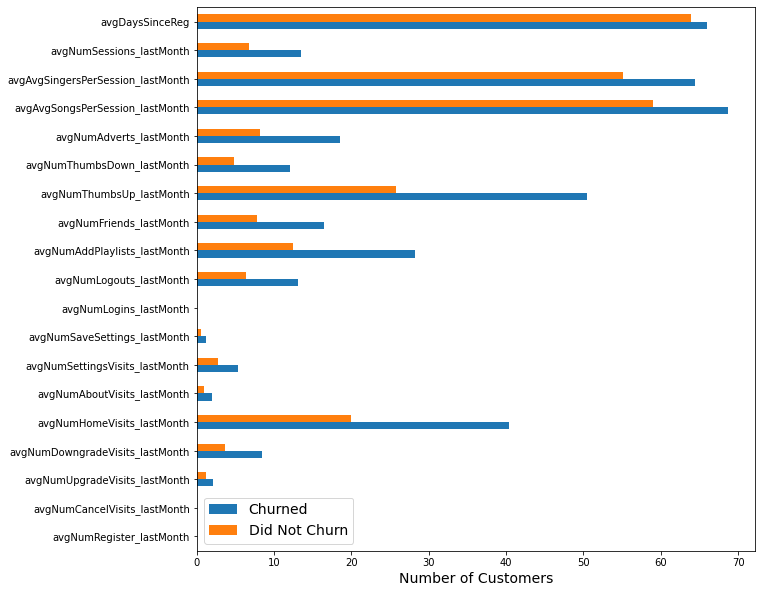

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
all_data_pd_1.drop('churn', axis=1).T.plot.barh(ax=ax);
ax.set_xlabel("Number of Customers", fontsize=14)
ax.legend(["Churned", "Did Not Churn"], fontsize=14);

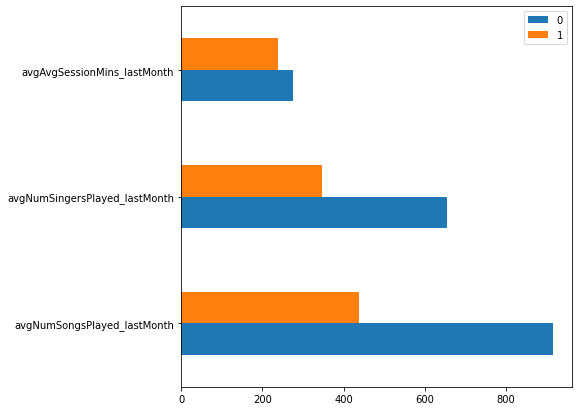

In [ ]:
all_data_pd_2.drop('churn', axis=1).T.plot.barh(figsize=(7,7));

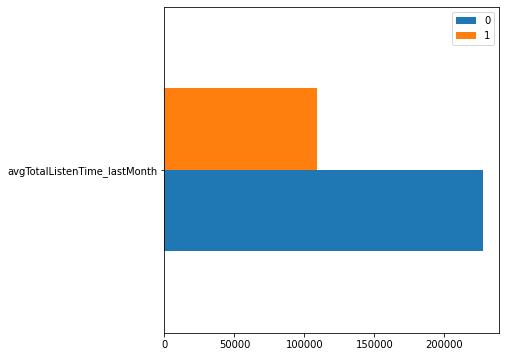

In [ ]:
all_data_pd_3.drop('churn', axis=1).T.plot.barh(figsize=(6,6));

In [ ]:
# 'level_lastMonth', 'gender',

all_data_pd_4 = all_data \
.filter(all_data.month_num>=1) \
.select('level_lastMonth', 'churn') \
.groupBy('churn') \
.agg(count(all_data.level_lastMonth).alias('level_lastMonth')).toPandas()

In [ ]:
all_data \
.filter(all_data.month_num>=1) \
.select('level_lastMonth', 'churn') \
.groupBy('churn', 'level_lastMonth').count().show()

+-----+---------------+-----+
|churn|level_lastMonth|count|
+-----+---------------+-----+
|    1|              0|    6|
|    0|              1|   84|
|    0|              0|   51|
|    1|              1|   37|
|    0|           null|   13|
+-----+---------------+-----+



In [ ]:
all_data_pd_4 = all_data \
.filter(all_data.month_num>=1) \
.select('level_lastMonth', 'churn') \
.groupBy('churn', 'level_lastMonth').count().toPandas()

In [ ]:
all_data_pd_4.head()

,churn,level_lastMonth,count
0,1,0,6
1,0,1,84
2,0,0,51
3,1,1,37
4,0,None,13


In [ ]:
all_data_pd_4.groupby(['churn', 'level_lastMonth']).agg({'count':'sum'})

count
churn level_lastMonth       
0     0                   51
      1                   84
1     0                    6
      1                   37

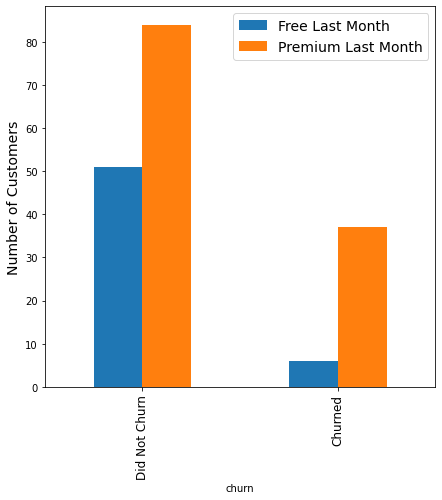

In [ ]:

fig, ax = plt.subplots(figsize=(7,7));
all_data_pd_4.groupby(['churn', 'level_lastMonth']).agg({'count':'sum'}).unstack().plot.bar(ax=ax);
ax.legend(["Free Last Month", "Premium Last Month"], fontsize=14);
ax.set_xticklabels(["Did Not Churn","Churned"], fontsize=12);
ax.set_ylabel("Number of Customers", fontsize=14);

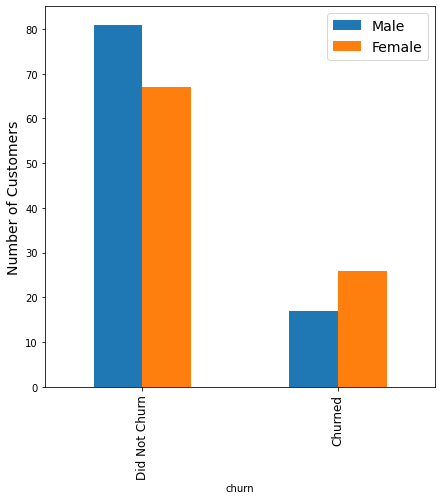

In [ ]:
all_data_pd_5 = all_data \
.filter(all_data.month_num>=1) \
.select('gender', 'churn') \
.groupBy('churn', 'gender').count().toPandas()

all_data_pd_5.groupby(['churn', 'gender']).agg({'count':'sum'})

fig, ax = plt.subplots(figsize=(7,7));
all_data_pd_5.groupby(['churn', 'gender']).agg({'count':'sum'}).unstack().plot.bar(ax=ax);
ax.legend(["Male", "Female"], fontsize=14);
ax.set_xticklabels(["Did Not Churn","Churned"], fontsize=12);
ax.set_ylabel("Number of Customers", fontsize=14);

In [ ]:
# visualize 1 month lag values
all_data_pd = all_data \
.filter(all_data.month_num>=1) \
.select('numRegister_lastMonth','numCancelVisits_lastMonth',\
        'numUpgradeVisits_lastMonth', 'numDowngradeVisits_lastMonth',\
        'numHomeVisits_lastMonth', 'numAboutVisits_lastMonth',\
        'numSettingsVisits_lastMonth', 'numSaveSettings_lastMonth',\
        'numLogins_lastMonth', 'numLogouts_lastMonth',\
        'numAddPlaylists_lastMonth', 'numFriends_lastMonth',\
        'numThumbsUp_lastMonth', 'numThumbsDown_lastMonth',\
        'numAdverts_lastMonth', 'numSongsPlayed_lastMonth',\
        'totalListenTime_lastMonth', 'avgSongsPerSession_lastMonth',\
        'numSingersPlayed_lastMonth', 'avgSingersPerSession_lastMonth',\
        'avgSessionMins_lastMonth', 'numSessions_lastMonth',\
        'level_lastMonth', 'gender', 'daysSinceReg', 'churn'
        ).toPandas()

In [ ]:
all_data_pd.head()

,numRegister_lastMonth,numCancelVisits_lastMonth,numUpgradeVisits_lastMonth,numDowngradeVisits_lastMonth,numHomeVisits_lastMonth,numAboutVisits_lastMonth,numSettingsVisits_lastMonth,numSaveSettings_lastMonth,numLogins_lastMonth,numLogouts_lastMonth,numAddPlaylists_lastMonth,numFriends_lastMonth,numThumbsUp_lastMonth,numThumbsDown_lastMonth,numAdverts_lastMonth,numSongsPlayed_lastMonth,totalListenTime_lastMonth,avgSongsPerSession_lastMonth,numSingersPlayed_lastMonth,avgSingersPerSession_lastMonth,avgSessionMins_lastMonth,numSessions_lastMonth,level_lastMonth,gender,daysSinceReg,churn
0,0,0,1,0,6,0,0,0,0,2,2,3,6,1,22,120,28266.62965,30.000000,116,29.500000,112.033333,4,0,1,35,0
1,0,0,2,3,14,2,3,0,0,3,6,4,15,6,7,267,64662.97119,53.400000,243,52.400000,220.190000,5,1,0,56,0
2,0,0,0,22,99,2,8,3,0,36,68,37,76,16,4,1939,481095.66548,161.583333,1286,145.916667,665.200000,12,1,1,102,0
3,0,0,2,0,6,0,2,0,0,1,3,1,4,1,13,109,27828.06488,27.250000,102,26.500000,113.125000,4,0,0,51,0
4,0,0,0,13,54,1,10,1,0,18,27,16,47,7,0,1034,258535.75985,147.714286,791,137.714286,538.289583,8,1,0,33,0


In [ ]:
all_data_pd[all_data_pd['numCancelVisits_lastMonth']>0].head()

,numRegister_lastMonth,numCancelVisits_lastMonth,numUpgradeVisits_lastMonth,numDowngradeVisits_lastMonth,numHomeVisits_lastMonth,numAboutVisits_lastMonth,numSettingsVisits_lastMonth,numSaveSettings_lastMonth,numLogins_lastMonth,numLogouts_lastMonth,numAddPlaylists_lastMonth,numFriends_lastMonth,numThumbsUp_lastMonth,numThumbsDown_lastMonth,numAdverts_lastMonth,numSongsPlayed_lastMonth,totalListenTime_lastMonth,avgSongsPerSession_lastMonth,numSingersPlayed_lastMonth,avgSingersPerSession_lastMonth,avgSessionMins_lastMonth,numSessions_lastMonth,level_lastMonth,gender,daysSinceReg,churn


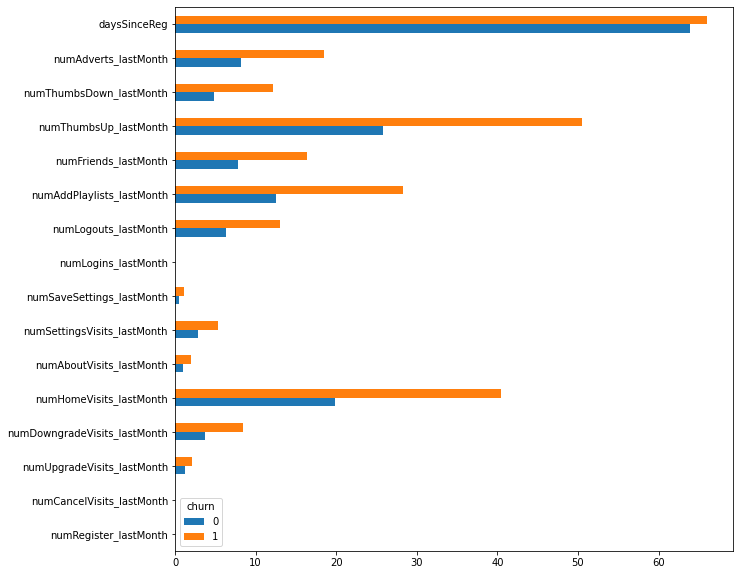

In [ ]:

all_data_pd.groupby('churn').agg({'numRegister_lastMonth':'mean',\
                                  'numCancelVisits_lastMonth':'mean',\
                                  'numUpgradeVisits_lastMonth':'mean',\
                                  'numDowngradeVisits_lastMonth':'mean',\
                                  'numHomeVisits_lastMonth':'mean',\
                                  'numAboutVisits_lastMonth':'mean',\
                                  'numSettingsVisits_lastMonth':'mean',\
                                  'numSaveSettings_lastMonth':'mean',\
                                  'numLogins_lastMonth':'mean',\
                                  'numLogouts_lastMonth':'mean',\
                                  'numAddPlaylists_lastMonth':'mean',\
                                  'numFriends_lastMonth':'mean',\
                                  'numThumbsUp_lastMonth':'mean',\
                                  'numThumbsDown_lastMonth':'mean',\
                                  'numAdverts_lastMonth':'mean',\
                                  'daysSinceReg':'mean'
                                  #'numSongsPlayed_lastMonth':'mean'
                                  #'totalListenTime_lastMonth':'mean'
                                 }).T.plot.barh(figsize=(10,10));

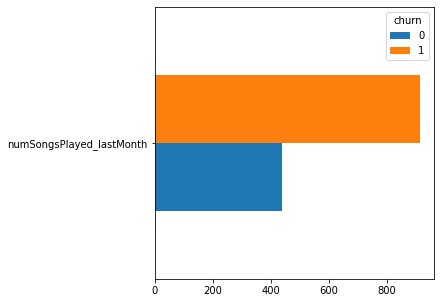

In [ ]:
all_data_pd.groupby('churn').agg({'numSongsPlayed_lastMonth':'mean'}).T.plot.barh(figsize=(5,5));

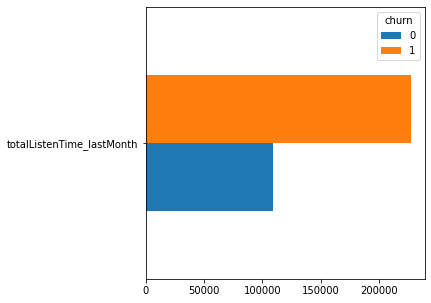

In [ ]:
all_data_pd.groupby('churn').agg({'totalListenTime_lastMonth':'mean'}).T.plot.barh(figsize=(5,5));

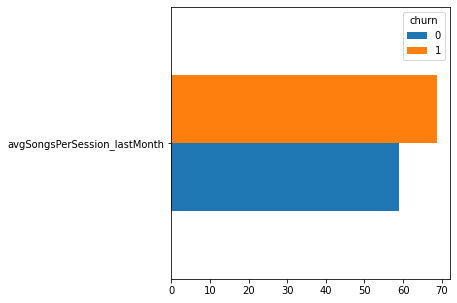

In [ ]:
all_data_pd.groupby('churn').agg({'avgSongsPerSession_lastMonth':'mean'}).T.plot.barh(figsize=(5,5));

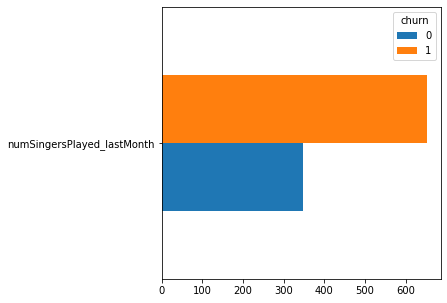

In [ ]:
all_data_pd.groupby('churn').agg({'numSingersPlayed_lastMonth':'mean'}).T.plot.barh(figsize=(5,5));

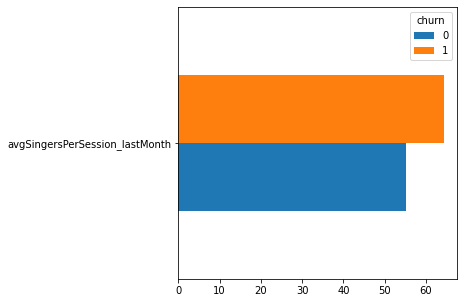

In [ ]:
all_data_pd.groupby('churn').agg({'avgSingersPerSession_lastMonth':'mean'}).T.plot.barh(figsize=(5,5));

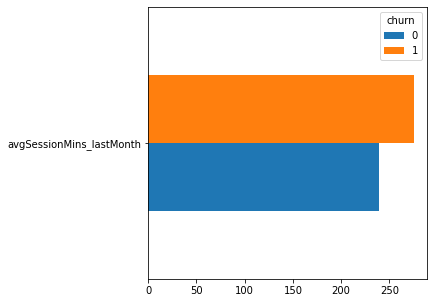

In [ ]:
all_data_pd.groupby('churn').agg({'avgSessionMins_lastMonth':'mean'}).T.plot.barh(figsize=(5,5));

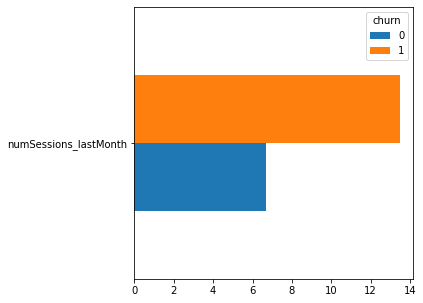

In [ ]:
all_data_pd.groupby('churn').agg({'numSessions_lastMonth':'mean'}).T.plot.barh(figsize=(5,5));

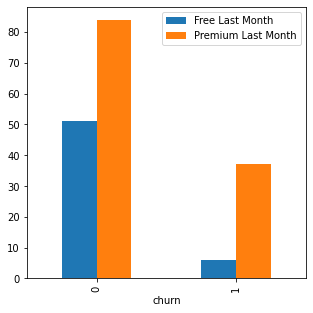

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
all_data_pd.groupby(['churn', 'level_lastMonth']).agg({'level_lastMonth':'count'}).unstack().plot.bar(ax=ax);
ax.legend(["Free Last Month", "Premium Last Month"]);

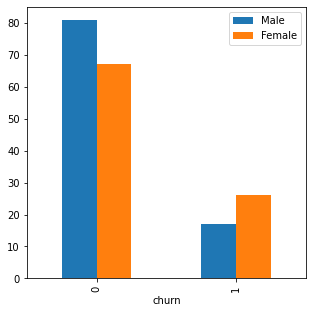

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
all_data_pd.groupby(['churn', 'gender']).agg({'gender':'count'}).unstack().plot.bar(ax=ax);
ax.legend(["Male", "Female"]);

In [ ]:
all_data_pd.churn.value_counts()

0    148
1     43
Name: churn, dtype: int64

# Feature Engineering

In [ ]:
# Engineer diffs between last months stats and moving averages.
# for the small dataset, the differences will be 0 since there were only 2 months
all_data = all_data.withColumn('diff_numRegister', (all_data['numRegister_lastMonth'] - all_data['numRegister_movAvg']))
all_data = all_data.withColumn('diff_numCancelVisits', (all_data['numCancelVisits_lastMonth'] - all_data['numCancelVisits_movAvg']))
all_data = all_data.withColumn('diff_numUpgradeVisits', (all_data['numUpgradeVisits_lastMonth'] - all_data['numUpgradeVisits_movAvg']))
all_data = all_data.withColumn('diff_numDowngradeVisits', (all_data['numDowngradeVisits_lastMonth'] - all_data['numDowngradeVisits_movAvg']))
all_data = all_data.withColumn('diff_numHomeVisits', (all_data['numHomeVisits_lastMonth'] - all_data['numHomeVisits_movAvg']))
all_data = all_data.withColumn('diff_numAboutVisits', (all_data['numAboutVisits_lastMonth'] - all_data['numAboutVisits_movAvg']))
all_data = all_data.withColumn('diff_numSettingsVisits', (all_data['numSettingsVisits_lastMonth'] - all_data['numSettingsVisits_movAvg']))
all_data = all_data.withColumn('diff_numSaveSettings', (all_data['numSaveSettings_lastMonth'] - all_data['numSaveSettings_movAvg']))
all_data = all_data.withColumn('diff_numLogins', (all_data['numLogins_lastMonth'] - all_data['numLogins_movAvg']))
all_data = all_data.withColumn('diff_numLogouts', (all_data['numLogouts_lastMonth'] - all_data['numLogouts_movAvg']))
all_data = all_data.withColumn('diff_numAddPlaylists', (all_data['numAddPlaylists_lastMonth'] - all_data['numAddPlaylists_movAvg']))
all_data = all_data.withColumn('diff_numFriends', (all_data['numFriends_lastMonth'] - all_data['numFriends_movAvg']))
all_data = all_data.withColumn('diff_numThumbsUp', (all_data['numThumbsUp_lastMonth'] - all_data['numThumbsUp_movAvg']))
all_data = all_data.withColumn('diff_numThumbsDown', (all_data['numThumbsDown_lastMonth'] - all_data['numThumbsDown_movAvg']))
all_data = all_data.withColumn('diff_numAdverts', (all_data['numAdverts_lastMonth'] - all_data['numAdverts_movAvg']))
all_data = all_data.withColumn('diff_numSongsPlayed', (all_data['numSongsPlayed_lastMonth'] - all_data['numSongsPlayed_movAvg']))
all_data = all_data.withColumn('diff_totalListenTime', (all_data['totalListenTime_lastMonth'] - all_data['totalListenTime_movAvg']))
all_data = all_data.withColumn('diff_avgSongsPerSession', (all_data['avgSongsPerSession_lastMonth'] - all_data['avgSongsPerSession_movAvg']))
all_data = all_data.withColumn('diff_numSingersPlayed', (all_data['numSingersPlayed_lastMonth'] - all_data['numSingersPlayed_movAvg']))
all_data = all_data.withColumn('diff_avgSingersPerSession', (all_data['avgSingersPerSession_lastMonth'] - all_data['avgSingersPerSession_movAvg']))
all_data = all_data.withColumn('diff_avgSessionMins', (all_data['avgSessionMins_lastMonth'] - all_data['avgSessionMins_movAvg']))
all_data = all_data.withColumn('diff_numSessions', (all_data['numSessions_lastMonth'] - all_data['numSessions_movAvg']))

In [ ]:
all_data.show(3)

+------+---------+-----------+---------------+----------------+------------------+-------------+--------------+-----------------+---------------+---------+----------+---------------+----------+-----------+-------------+----------+--------------+------------------+------------------+----------------+--------------------+------------------+-----------+-----+------+------------+-----+---------------------+-------------------------+--------------------------+----------------------------+-----------------------+------------------------+---------------------------+-------------------------+-------------------+--------------------+-------------------------+--------------------+---------------------+-----------------------+--------------------+------------------------+-------------------------+----------------------------+--------------------------+------------------------------+------------------------+---------------------+---------------+-------------------+---------------+-----------------

In [ ]:
# convert userId, gender, level, level_lastMonth to numeric
convert_numeric = ['userId', 'level', 'gender', 'level_lastMonth']
for feat in convert_numeric:
    featName = feat + "_n"
    all_data = all_data.withColumn(featName, all_data[feat].cast("float"))
    all_data = all_data.drop(feat)

In [ ]:

# fill na/null values with 0
all_data = all_data.na.fill(0.0)

In [ ]:
out_path = "all_data_small.csv"
all_data.write.mode('overwrite').save(out_path, format="csv", header=True)

In [ ]:
# If needed
out_path = "all_data_small.csv"
all_data = spark.read.csv(out_path, header=True, inferSchema=True)

In [ ]:
all_data.persist()

DataFrame[month_num: int, numRegister: int, numCancelVisits: int, numUpgradeVisits: int, numDowngradeVisits: int, numHomeVisits: int, numAboutVisits: int, numSettingsVisits: int, numSaveSettings: int, numLogins: int, numLogouts: int, numAddPlaylists: int, numFriends: int, numThumbsUp: int, numThumbsDown: int, numAdverts: int, numSongsPlayed: int, totalListenTime: double, avgSongsPerSession: double, numSingersPlayed: int, avgSingersPerSession: double, avgSessionMins: double, numSessions: int, daysSinceReg: int, churn: int, numRegister_lastMonth: int, numCancelVisits_lastMonth: int, numUpgradeVisits_lastMonth: int, numDowngradeVisits_lastMonth: int, numHomeVisits_lastMonth: int, numAboutVisits_lastMonth: int, numSettingsVisits_lastMonth: int, numSaveSettings_lastMonth: int, numLogins_lastMonth: int, numLogouts_lastMonth: int, numAddPlaylists_lastMonth: int, numFriends_lastMonth: int, numThumbsUp_lastMonth: int, numThumbsDown_lastMonth: int, numAdverts_lastMonth: int, numSongsPlayed_lastM

# Modeling

In [ ]:
all_data.columns

['month_num',
 'numRegister',
 'numCancelVisits',
 'numUpgradeVisits',
 'numDowngradeVisits',
 'numHomeVisits',
 'numAboutVisits',
 'numSettingsVisits',
 'numSaveSettings',
 'numLogins',
 'numLogouts',
 'numAddPlaylists',
 'numFriends',
 'numThumbsUp',
 'numThumbsDown',
 'numAdverts',
 'numSongsPlayed',
 'totalListenTime',
 'avgSongsPerSession',
 'numSingersPlayed',
 'avgSingersPerSession',
 'avgSessionMins',
 'numSessions',
 'daysSinceReg',
 'churn',
 'numRegister_lastMonth',
 'numCancelVisits_lastMonth',
 'numUpgradeVisits_lastMonth',
 'numDowngradeVisits_lastMonth',
 'numHomeVisits_lastMonth',
 'numAboutVisits_lastMonth',
 'numSettingsVisits_lastMonth',
 'numSaveSettings_lastMonth',
 'numLogins_lastMonth',
 'numLogouts_lastMonth',
 'numAddPlaylists_lastMonth',
 'numFriends_lastMonth',
 'numThumbsUp_lastMonth',
 'numThumbsDown_lastMonth',
 'numAdverts_lastMonth',
 'numSongsPlayed_lastMonth',
 'totalListenTime_lastMonth',
 'avgSongsPerSession_lastMonth',
 'numSingersPlayed_lastMonth',

In [ ]:
# drop month 0 since we do not have old information to predict churn for this month
# keep only features to be trained and labels

model_data = all_data \
.filter(all_data.month_num>0) \
.select('userId_n', 'month_num', 'numRegister_lastMonth', 'numCancelVisits_lastMonth',\
        'numUpgradeVisits_lastMonth', 'numDowngradeVisits_lastMonth',\
        'numHomeVisits_lastMonth', 'numAboutVisits_lastMonth',\
        'numSettingsVisits_lastMonth', 'numSaveSettings_lastMonth',\
        'numLogins_lastMonth', 'numLogouts_lastMonth', \
        'numAddPlaylists_lastMonth', 'numFriends_lastMonth',\
        'numThumbsUp_lastMonth', 'numThumbsDown_lastMonth',\
        'numAdverts_lastMonth', 'numSongsPlayed_lastMonth',\
        'totalListenTime_lastMonth', 'avgSongsPerSession_lastMonth',\
        'numSingersPlayed_lastMonth', 'avgSingersPerSession_lastMonth',\
        'avgSessionMins_lastMonth', 'numSessions_lastMonth',\
        'level_lastMonth_n', 'numRegister_movAvg', 'numCancelVisits_movAvg',\
        'numUpgradeVisits_movAvg', 'numDowngradeVisits_movAvg',\
        'numHomeVisits_movAvg', 'numAboutVisits_movAvg',\
        'numSettingsVisits_movAvg', 'numSaveSettings_movAvg',\
        'numLogins_movAvg', 'numLogouts_movAvg',\
        'numAddPlaylists_movAvg', 'numFriends_movAvg',\
        'numThumbsUp_movAvg', 'numThumbsDown_movAvg',\
        'numAdverts_movAvg', 'numSongsPlayed_movAvg',\
        'totalListenTime_movAvg', 'avgSongsPerSession_movAvg',\
        'numSingersPlayed_movAvg', 'avgSingersPerSession_movAvg',\
        'avgSessionMins_movAvg', 'numSessions_movAvg',\
        'diff_numRegister', 'diff_numCancelVisits',\
        'diff_numUpgradeVisits', 'diff_numDowngradeVisits',\
        'diff_numHomeVisits', 'diff_numAboutVisits',\
        'diff_numSettingsVisits', 'diff_numSaveSettings',\
        'diff_numLogins', 'diff_numLogouts',\
        'diff_numAddPlaylists', 'diff_numFriends',\
        'diff_numThumbsUp', 'diff_numThumbsDown',\
        'diff_numAdverts', 'diff_numSongsPlayed',\
        'diff_totalListenTime', 'diff_avgSongsPerSession',\
        'diff_numSingersPlayed', 'diff_avgSingersPerSession',
        'diff_avgSessionMins', 'diff_numSessions',\
        'gender_n', 'daysSinceReg', 'churn'
        ).withColumnRenamed('churn', 'label')

model_data.show(1)

+--------+---------+---------------------+-------------------------+--------------------------+----------------------------+-----------------------+------------------------+---------------------------+-------------------------+-------------------+--------------------+-------------------------+--------------------+---------------------+-----------------------+--------------------+------------------------+-------------------------+----------------------------+--------------------------+------------------------------+------------------------+---------------------+-----------------+------------------+----------------------+-----------------------+-------------------------+--------------------+---------------------+------------------------+----------------------+----------------+-----------------+----------------------+-----------------+------------------+--------------------+-----------------+---------------------+----------------------+-------------------------+-----------------------+---

In [ ]:
model_data.select([count(when(col(c).isNull(), c)).alias(c) for c in model_data.columns]).show()

+--------+---------+---------------------+-------------------------+--------------------------+----------------------------+-----------------------+------------------------+---------------------------+-------------------------+-------------------+--------------------+-------------------------+--------------------+---------------------+-----------------------+--------------------+------------------------+-------------------------+----------------------------+--------------------------+------------------------------+------------------------+---------------------+-----------------+------------------+----------------------+-----------------------+-------------------------+--------------------+---------------------+------------------------+----------------------+----------------+-----------------+----------------------+-----------------+------------------+--------------------+-----------------+---------------------+----------------------+-------------------------+-----------------------+---

In [ ]:
# for small dataset with 2 months, just use randomSplit
# for bigger datasets with multiple months, can split according to months
train,test = model_data.randomSplit([0.8, 0.2], seed=50)

In [ ]:
# for small dataset, just train with last month's stats since there are only 2 months
# for large dataset, can train with last month's stats, moving averages and diffs

# small dataset
inputColumns = ['userId_n', 'month_num', 'numRegister_lastMonth', 'numCancelVisits_lastMonth',\
                'numUpgradeVisits_lastMonth', 'numDowngradeVisits_lastMonth',\
                'numHomeVisits_lastMonth', 'numAboutVisits_lastMonth',\
                'numSettingsVisits_lastMonth', 'numSaveSettings_lastMonth',\
                'numLogins_lastMonth', 'numLogouts_lastMonth', \
                'numAddPlaylists_lastMonth', 'numFriends_lastMonth',\
                'numThumbsUp_lastMonth', 'numThumbsDown_lastMonth',\
                'numAdverts_lastMonth', 'numSongsPlayed_lastMonth',\
                'totalListenTime_lastMonth', 'avgSongsPerSession_lastMonth',\
                'numSingersPlayed_lastMonth', 'avgSingersPerSession_lastMonth',\
                'avgSessionMins_lastMonth', 'numSessions_lastMonth',\
                'level_lastMonth_n', 'gender_n', 'daysSinceReg']


assembler = VectorAssembler(inputCols=inputColumns, outputCol="FeaturesVec")
#data = assembler.transform(model_data)

scaler = StandardScaler(inputCol="FeaturesVec", outputCol="features", withMean=True, withStd=True)
#scalerModel = scaler.fit(data)
#data = scalerModel.transform(data)
#data = data.select(data.churn.alias("label"), data.ScaledFeatures.alias("features"))

# set max_iter to 30 for prototype, instead of the default 100, to save time

# Logistic Regression
lr=LogisticRegression(maxIter=30)
pipeline_lr = Pipeline(stages=[assembler, scaler, lr])

# Support Vector Machine Classifier
svc = LinearSVC(maxIter=30)
pipeline_svc = Pipeline(stages=[assembler, scaler, svc])

# Gradient Boosted Trees
gbt = GBTClassifier(maxIter=20, seed=42)
pipeline_gbt = Pipeline(stages=[assembler, scaler, gbt])

In [ ]:
# logistic Regression
# Using default L2 regularization
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam,[0.0, 0.05, 0.1, 0.2, 0.5]) \
    .build()

cv_lr = CrossValidator(estimator=pipeline_lr,\
                       estimatorParamMaps=paramGrid,\
                       evaluator=MulticlassClassificationEvaluator(),\
                       numFolds=5,\
                       seed=42
                      )
cvModel_lr = cv_lr.fit(train)

In [ ]:
#best_lr = cvModel_lr.bestModel
#print("Best reg param: "+best_lr._java_obj.getRegParam()

In [ ]:
cvModel_lr.avgMetrics

[0.7825155112517618,
 0.7785621304019302,
 0.7919397664111452,
 0.8026539045189003,
 0.7732925103716157]

In [ ]:
lr_results = cvModel_lr.transform(test)

In [ ]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print("Logistic Regression Model --- Accuracy is: ")
print(evaluator.evaluate(lr_results, {evaluator.metricName: "accuracy"}))

Logistic Regression Model --- Accuracy is: 
0.7037037037037037


In [ ]:
print("Logistic Regression Model --- F1-Score is: ")
print(evaluator.evaluate(lr_results, {evaluator.metricName: "f1"}))

Logistic Regression Model --- F1-Score is: 
0.5813204508856683


In [ ]:
# Linear Support Vector Machine
# Using L2 regularization
paramGrid = ParamGridBuilder() \
    .addGrid(svc.regParam,[0.0, 0.05, 0.1, 0.2, 0.5]) \
    .build()

cv_svc = CrossValidator(estimator=pipeline_svc,\
                       estimatorParamMaps=paramGrid,\
                       evaluator=MulticlassClassificationEvaluator(),\
                       numFolds=5,\
                       seed=42
                      )
cvModel_svc = cv_svc.fit(train)

In [ ]:
cvModel_svc.avgMetrics

[0.7808340133653024,
 0.7869902714616502,
 0.7919397664111452,
 0.8079449098099056,
 0.7764331262875956]

In [ ]:
svc_results = cvModel_svc.transform(test)

In [ ]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print("Linear SVC Model --- Accuracy is: ")
print(evaluator.evaluate(svc_results, {evaluator.metricName: "accuracy"}))

Linear SVC Model --- Accuracy is: 
0.7037037037037037


In [ ]:
print("Linear SVC Model --- F1-Score is: ")
print(evaluator.evaluate(svc_results, {evaluator.metricName: "f1"}))

Linear SVC Model --- F1-Score is: 
0.5813204508856683


In [ ]:
# Gradient Boosted Trees
paramGrid = ParamGridBuilder() \
            .addGrid(gbt.minInstancesPerNode,[1, 5, 10, 20, 50]) \
            .addGrid(gbt.maxDepth,[5, 7, 9])\
            .addGrid(gbt.subsamplingRate,[0.5,0.75,1.0])\
            .build()

cv_gbt = CrossValidator(estimator=pipeline_gbt,\
                        estimatorParamMaps=paramGrid,\
                        evaluator=MulticlassClassificationEvaluator(),\
                        numFolds=5,\
                        seed=42
                       )
cvModel_gbt = cv_gbt.fit(train)

In [ ]:
cvModel_gbt.avgMetrics

[0.7316073684900805,
 0.7969804884831481,
 0.8152777621013245,
 0.7451646969545298,
 0.7938149698647992,
 0.804464490536068,
 0.7377419112564314,
 0.7935822200848797,
 0.804464490536068,
 0.8113246877458442,
 0.7839869892310443,
 0.7832999921495747,
 0.7891908493620059,
 0.7830482701892276,
 0.7847723578796029,
 0.7794710094534867,
 0.7734965669383693,
 0.7746273588882198,
 0.7781937650433477,
 0.774767309323317,
 0.7833355030451401,
 0.7781937650433477,
 0.788232646666222,
 0.7668962010920204,
 0.7781937650433477,
 0.788232646666222,
 0.7668962010920204,
 0.744257482593786,
 0.7558644640876626,
 0.7681939691030013,
 0.744257482593786,
 0.7558644640876626,
 0.7681939691030013,
 0.744257482593786,
 0.7558644640876626,
 0.7681939691030013,
 0.6988111837510451,
 0.7322559066694522,
 0.7463845472363868,
 0.6988111837510451,
 0.7322559066694522,
 0.7463845472363868,
 0.6988111837510451,
 0.7322559066694522,
 0.7463845472363868]

In [ ]:
gbt_results = cvModel_gbt.transform(test)

In [ ]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print("GBT Model --- Accuracy is: ")
print(evaluator.evaluate(gbt_results, {evaluator.metricName: "accuracy"}))

GBT Model --- Accuracy is: 
0.7407407407407407


In [ ]:
print("GBT Model --- F1-Score is: ")
print(evaluator.evaluate(gbt_results, {evaluator.metricName: "f1"}))

GBT Model --- F1-Score is: 
0.6968913945658133


In [ ]:
# from https://stackoverflow.com/questions/51230726/extract-results-from-crossvalidator-with-paramgrid-in-pyspark

params = [{p.name: v for p, v in m.items()} for m in cvModel_gbt.getEstimatorParamMaps()]

pd.DataFrame.from_dict([
    {cvModel_gbt.getEvaluator().getMetricName(): metric, **ps} 
    for ps, metric in zip(params, cvModel_gbt.avgMetrics)
])

,f1,minInstancesPerNode,maxDepth,subsamplingRate
0,0.731607,1,5,0.50
1,0.796980,1,5,0.75
2,0.815278,1,5,1.00
3,0.745165,1,7,0.50
4,0.793815,1,7,0.75
5,0.804464,1,7,1.00
6,0.737742,1,9,0.50
7,0.793582,1,9,0.75
8,0.804464,1,9,1.00
9,0.811325,5,5,0.50


In [ ]:
# from https://blog.epigno.systems/2018/02/24/machine-learning-with-pyspark-feature-ranking/
cvModel_gbt.bestModel.stages

[VectorAssembler_4b47e8300c7a,
 StandardScalerModel: uid=StandardScaler_b248631ff310, numFeatures=27, withMean=true, withStd=true,
 GBTClassificationModel: uid = GBTClassifier_f83845f26375, numTrees=20, numClasses=2, numFeatures=27]

In [ ]:
cvModel_gbt.bestModel.stages[-1].featureImportances

SparseVector(27, {0: 0.1739, 4: 0.0566, 5: 0.1236, 6: 0.0192, 7: 0.0267, 8: 0.0289, 9: 0.0273, 11: 0.0092, 12: 0.0898, 13: 0.0162, 14: 0.071, 15: 0.0446, 16: 0.1908, 17: 0.0436, 18: 0.0028, 19: 0.0165, 20: 0.0065, 21: 0.0199, 23: 0.0107, 26: 0.0223})

In [ ]:
cvModel_gbt.bestModel.stages[-1].featureImportances.toArray()

array([0.17390549, 0.        , 0.        , 0.        , 0.05657933,
       0.12364736, 0.01917121, 0.02669068, 0.02886006, 0.02731507,
       0.        , 0.0091522 , 0.08979003, 0.01623645, 0.07099203,
       0.04460241, 0.19078232, 0.04358869, 0.00281517, 0.01648737,
       0.00652339, 0.01987034, 0.        , 0.01067876, 0.        ,
       0.        , 0.02231163])

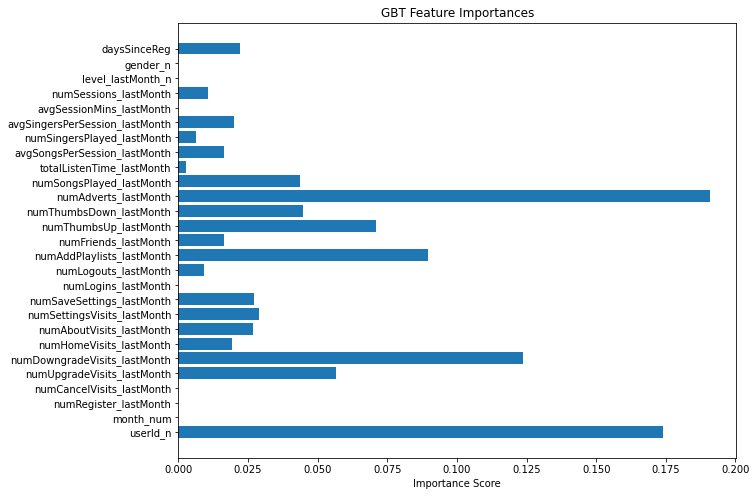

In [ ]:

# plot feature importances
importances = cvModel_gbt.bestModel.stages[-1].featureImportances.toArray()
features = ['userId_n', 'month_num', 'numRegister_lastMonth', 'numCancelVisits_lastMonth',\
            'numUpgradeVisits_lastMonth', 'numDowngradeVisits_lastMonth',\
            'numHomeVisits_lastMonth', 'numAboutVisits_lastMonth',\
            'numSettingsVisits_lastMonth', 'numSaveSettings_lastMonth',\
            'numLogins_lastMonth', 'numLogouts_lastMonth', \
            'numAddPlaylists_lastMonth', 'numFriends_lastMonth',\
            'numThumbsUp_lastMonth', 'numThumbsDown_lastMonth',\
            'numAdverts_lastMonth', 'numSongsPlayed_lastMonth',\
            'totalListenTime_lastMonth', 'avgSongsPerSession_lastMonth',\
            'numSingersPlayed_lastMonth', 'avgSingersPerSession_lastMonth',\
            'avgSessionMins_lastMonth', 'numSessions_lastMonth',\
            'level_lastMonth_n', 'gender_n', 'daysSinceReg']

y_pos = np.arange(len(features))
    
fig, ax = plt.subplots(figsize=(10,8))
ax.barh(y_pos, importances);
plt.yticks(y_pos, features);
plt.xlabel('Importance Score');
plt.title('GBT Feature Importances');